<a href="https://colab.research.google.com/github/itrail/GenderRecognitionCNN/blob/main/GenderRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#załączenie koniecznych bibliotek tensorflow i keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense 
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator #do kopiowania zdjecia z lekkimi modyfikacjami aby miec więcej próbek do uczenia
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#ustalenie połaczenia z dyskiem google

from google.colab import drive
drive.mount('/content/drive')
! ls "/content/drive/My Drive"

In [ ]:
#skopiowanie skompresowanych danych do uczenia, walidacji oraz testowania sieci neruronowej

! cp "/content/drive/My Drive/gender.zip" "gender.zip"

In [ ]:
#rozpakowanie archiwum z danymi

! unzip gender.zip

Archive:  gender.zip
replace gender/test/man/face_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y a
  inflating: gender/test/man/face_0.jpg  
replace gender/test/man/face_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y, a
  inflating: gender/test/man/face_1.jpg  
replace gender/test/man/face_10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: gender/test/man/face_10.jpg  
replace gender/test/man/face_101.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace gender/test/man/face_101.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: gender/test/man/face_101.jpg  
  inflating: gender/test/man/face_103.jpg  
  inflating: gender/test/man/face_104.jpg  
  inflating: gender/test/man/face_105.jpg  
  inflating: gender/test/man/face_106.jpg  
  inflating: gender/test/man/face_107.jpg  
  inflating: gender/test/man/face_108.jpg  
  inflating: gender/test/man/face_109.jpg  
  inflating: gender/test/man/face_11.jpg  
  inflating: gender/test/man/face_110.

In [ ]:
#wskazanie lokalizacji danych do trenowania, walidacji i testów
import os

main_dir = "/content/gender"
train_dir = os.path.join(main_dir,'train')
test_dir = os.path.join(main_dir,'test')
valid_dir = os.path.join(main_dir,'valid')

#wskazanie lokalizacji danych z oboma przypadkami do uczenia sie 

train_female_dir = os.path.join(train_dir,'woman')
train_male_dir = os.path.join(train_dir,'man')

In [ ]:
#ustalenie lokalizacji zdjęc dla obu płci do treningu

train_male_names = os.listdir(train_male_dir)
train_female_names = os.listdir(train_female_dir)

In [ ]:
#modyfikacja posiadanych danych tak by zyskać jeszcze więcej danych do uczenia oraz ustalenie lokalizacji poszczególnych danych do treningu, walidadcji i testu

train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2, rotation_range= 40, horizontal_flip= True)
test_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size = 20, class_mode = 'binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150,150), batch_size = 20, class_mode = 'binary')
valid_generator = validation_datagen.flow_from_directory(valid_dir, target_size=(150,150), batch_size = 20, class_mode = 'binary')

Found 1600 images belonging to 2 classes.
Found 340 images belonging to 2 classes.
Found 340 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'man': 0, 'woman': 1}

In [ ]:
#uzycie modelu sekwencyjnego

model = Sequential()

#dzielimy obraz na 16 mniejszych, szczegóły zapisujemy do macierzy 3x3, za pomocą braku paddingu nie tracimy żadnych danych pomiędzy mniejszymi częsciami obrazu
#aktywacja nieliniowymi funkcjami, a dane wejsciowe to obraz 150x150 w systemie barw rgb
model.add(Conv2D(16, (3,3),  padding="SAME", activation="relu", input_shape=(150, 150, 3)))

#wycianmy tylko częśc, która nas interesuje aby przyspieszyc proces uczenia
model.add(MaxPooling2D(pool_size=(2,2)))

#wycofanie połowy neuronów aby uniknąć przeuczenia
model.add(Dropout(0.5))

model.add(Conv2D(32, (3,3), padding="SAME", activation="relu", input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), padding="SAME", activation="relu", input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

#spłaszczenie do jednego wymiaru w celu połączenia warstw
model.add(Flatten())

#utworzenie wartstwy łączącej z 512 ukrytymi węzłami
model.add(Dense(512, activation="relu"))

#utworzenie warstwy wyjściowej z zero-jedynkową funkcją aktywacji
model.add(Dense(1, activation="sigmoid"))
#podsumowanie modelu
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 18, 64)       

In [ ]:
#kompilacja sieci neuronowej wraz z optymalizacją i oczekiwaniem wyniku w postaci binarnej funkcji straty krzyżowej entropii

model.compile(Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
#rozpoczęcie procesu uczenia neuronów w 40 cyklach(epokach) z wykorzystaniem danych walidacyjnych

history = model.fit(train_generator, epochs= 40, validation_data= valid_generator)

Epoch 1/40
80/80 [==============================] - 51s 631ms/step - loss: 0.9701 - accuracy: 0.5423 - val_loss: 0.6723 - val_accuracy: 0.5471
Epoch 2/40
80/80 [==============================] - 51s 631ms/step - loss: 0.6526 - accuracy: 0.6411 - val_loss: 0.5417 - val_accuracy: 0.7588
Epoch 3/40
80/80 [==============================] - 50s 629ms/step - loss: 0.5266 - accuracy: 0.7482 - val_loss: 0.4039 - val_accuracy: 0.8471
Epoch 4/40
80/80 [==============================] - 51s 632ms/step - loss: 0.4174 - accuracy: 0.8143 - val_loss: 0.3661 - val_accuracy: 0.8529
Epoch 5/40
80/80 [==============================] - 50s 625ms/step - loss: 0.3925 - accuracy: 0.8279 - val_loss: 0.3937 - val_accuracy: 0.8676
Epoch 6/40
80/80 [==============================] - 50s 626ms/step - loss: 0.4041 - accuracy: 0.8212 - val_loss: 0.4168 - val_accuracy: 0.8176
Epoch 7/40
80/80 [==============================] - 51s 632ms/step - loss: 0.3937 - accuracy: 0.8208 - val_loss: 0.3435 - val_accuracy: 0.8706

Text(0.5, 0, 'epoch')

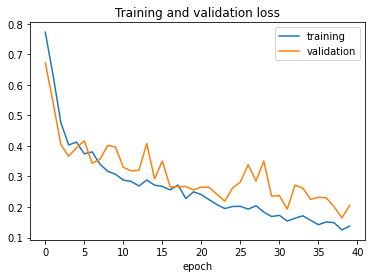

In [ ]:
#wykreslenie strat podczas nauki i walidacji

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and validation loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

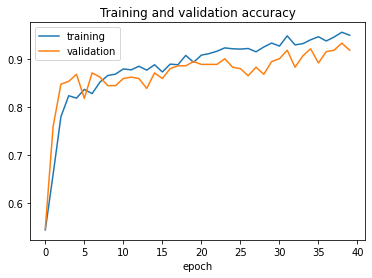

In [ ]:
#wykreslenie precyzji podczas nauki oraz walidacji

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')

In [ ]:
#poinformowanie o wyniku testu straty oraz precyzji nauczonej sieci

test_loss, test_acc = model.evaluate(test_generator)
print("Test loss: {}, Test accuracy: {}".format(test_loss, test_acc))

17/17 [==============================] - 3s 192ms/step - loss: 0.1994 - accuracy: 0.9294
Test loss: 0.19936881959438324, Test accuracy: 0.929411768913269


Saving drugafota.jpg to drugafota (2).jpg
Nazwa pliku: drugafota.jpg


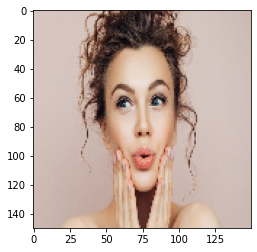

Kobieta


In [ ]:
#próba działania sieci na zdjęciach z dysku użytkownika

from google.colab import files
from keras.preprocessing import image
uploaded = files.upload()
for fname in uploaded.keys():
  img_path = "/content/"+fname
  img = image.load_img(img_path, target_size=(150, 150))
  images = image.img_to_array(img)
  images = np.expand_dims(images, axis=0)
  prediction = model.predict(images)
  print("Nazwa pliku: " + fname)
  plt.imshow(img, cmap="gray")

  plt.show()
  if prediction == 0:
    print("Facet")
  else:
    print("Kobieta")

In [ ]:
#zapisanie stworzonego modelu sieci neuronowej

model.save("model.h5")